In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
# imputer
from sklearn.impute import SimpleImputer, KNNImputer




url1 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
names = ["feature" + str(x) for x in range(1, 591)]
df1 = pd.read_csv(url1,sep=" ", names=names, na_values = "NaN",header=None)
df1.head()

url2 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
df2 = pd.read_csv(url2,sep=" ",names = ["Result","Date"])

#df2.columns =['Pass/Fail','Date']
df2.head()




#Convertion of Date into Datetime from Object(String) data types
df2['Date'] = pd.to_datetime(df2['Date'])
df2.dtypes



#Joinig TWO df1 and df2 Dataframe naming SECOM
Secom = pd.concat([df1,df2],axis = 1)
print(Secom)

Secom = Secom.drop(['Date'],axis=1)
                   
# establish target and features of the manufacturing data
# set the target to the encoded manufacturing outcome column
y = Secom[['Result']]
# set the features as the rest of the dataset after dropping the features that are no
x = Secom.drop(['Result'], axis=1)

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

#Splitting data


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1,stratify = y)



# getting the counts
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)




#Removing features having Missing ratio more than 50%


def percentna(dataframe, threshold):
    columns = dataframe.columns[(dataframe.isnull().sum()/len(dataframe))>threshold]
    return columns.tolist()

 

na_columns = percentna(x_train, 0.5)
len(na_columns)
x_train_dn = x_train.drop(na_columns, axis=1)
x_train_dn.shape





#Low Variance Filter
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(x_train_dn)

 

constant_columns = [column for column in x_train_dn.columns
                    if column not in x_train_dn.columns[var_thres.get_support()]]


print(len(constant_columns))

x_train_lv = x_train_dn.drop(constant_columns,axis=1)

      feature1  feature2   feature3   feature4  feature5  feature6  feature7  \
0      3030.93   2564.00  2187.7333  1411.1265    1.3602     100.0   97.6133   
1      3095.78   2465.14  2230.4222  1463.6606    0.8294     100.0  102.3433   
2      2932.61   2559.94  2186.4111  1698.0172    1.5102     100.0   95.4878   
3      2988.72   2479.90  2199.0333   909.7926    1.3204     100.0  104.2367   
4      3032.24   2502.87  2233.3667  1326.5200    1.5334     100.0  100.3967   
...        ...       ...        ...        ...       ...       ...       ...   
1562   2899.41   2464.36  2179.7333  3085.3781    1.4843     100.0   82.2467   
1563   3052.31   2522.55  2198.5667  1124.6595    0.8763     100.0   98.4689   
1564   2978.81   2379.78  2206.3000  1110.4967    0.8236     100.0   99.4122   
1565   2894.92   2532.01  2177.0333  1183.7287    1.5726     100.0   98.7978   
1566   2944.92   2450.76  2195.4444  2914.1792    1.5978     100.0   85.1011   

      feature8  feature9  feature10  ..

In [8]:
def IQR_outliers(data,limit=1.5):
    numColumns = data.select_dtypes(include=np.number).columns.tolist(); # extract list of numeric columns
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3-Q1;
    outliers=((data[numColumns] < (Q1 - limit*IQR)) | (data[numColumns] > (Q3 + limit*IQR))).sum()*100/data.shape[0]
    return outliers 
from sklearn.preprocessing import QuantileTransformer
x_train_lv = x_train_lv.copy()
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state= 42)
df_outliers = pd.DataFrame(quantile_transformer.fit_transform(x_train_lv),columns=x_train_lv.columns)
outliers = IQR_outliers(df_outliers)

In [9]:
# latest information available
x_train_LastFill2 = df_outliers.copy()
x_train_LastFill2.fillna(method='ffill', inplace=True)
x_train_LastFill2.fillna(method='bfill', inplace=True)
x_train_LastFill2

x_train_LastFill2.isna().sum().sort_values(ascending=False).head(10)



feature1      0
feature434    0
feature391    0
feature390    0
feature389    0
feature388    0
feature387    0
feature386    0
feature378    0
feature377    0
dtype: int64

In [10]:
x_test_LastFill2 = x_test.copy()
x_test_LastFill2.fillna(method='ffill', inplace=True)
x_test_LastFill2.fillna(method='bfill', inplace=True)
x_test_LastFill2

x_test_LastFill2.isna().sum().sort_values(ascending=False).head(10)

feature1      0
feature406    0
feature390    0
feature391    0
feature392    0
feature393    0
feature394    0
feature395    0
feature396    0
feature397    0
dtype: int64

## PCA

Covariance Matrix 
 [[ 9.59456065e-03 -1.39275617e-03 -1.35594413e-04 ... -1.15333930e-04
  -2.41371498e-04 -2.34418019e-04]
 [-1.39275617e-03  9.57508161e-03  4.90101542e-04 ...  1.38145799e-04
  -2.26836483e-05  4.01885164e-04]
 [-1.35594413e-04  4.90101542e-04  1.03561989e-02 ... -3.47605869e-04
  -3.13763168e-04 -3.51138301e-04]
 ...
 [-1.15333930e-04  1.38145799e-04 -3.47605869e-04 ...  9.58230629e-03
   9.33829289e-03  5.16082917e-03]
 [-2.41371498e-04 -2.26836483e-05 -3.13763168e-04 ...  9.33829289e-03
   9.70892348e-03  5.14952205e-03]
 [-2.34418019e-04  4.01885164e-04 -3.51138301e-04 ...  5.16082917e-03
   5.14952205e-03  1.34653087e-02]]
Cumulative Variance Explained [  3.37590643   6.22229407   8.89337258  10.91412528  12.84502615
  14.6180843   16.32251993  18.00486491  19.64757037  21.2629648
  22.8240008   24.3003238   25.76911828  27.1324871   28.45393123
  29.75473828  31.01614553  32.22629428  33.37948594  34.49450727
  35.58964328  36.66381368  37.68953705  38.7031611

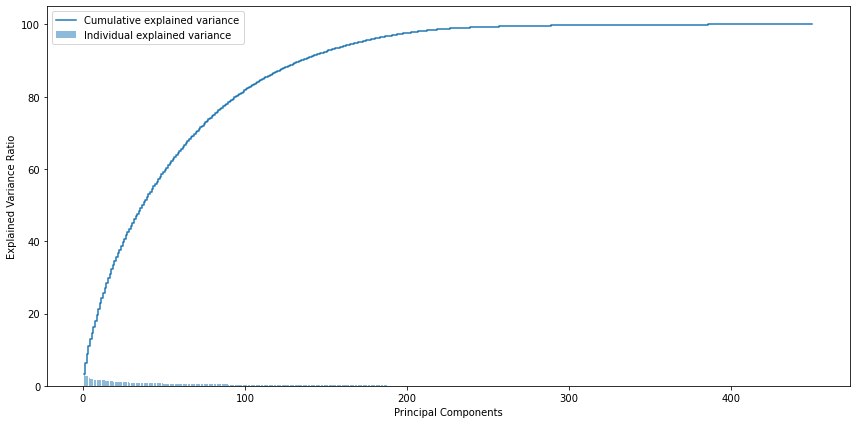

           0         1         2         3         4         5         6    \
0     0.499283 -0.374800  0.419610 -0.162629  0.052313  0.446888  0.217836   
1     0.425774  0.257490 -0.731066  0.009706  0.006652 -0.061745  0.174110   
2    -0.512033  0.325087  0.214273 -0.475149  0.153862  0.546591  0.304635   
3    -0.452444 -0.362363  0.273196  0.381815 -0.516857 -0.105592 -0.136868   
4    -0.665662  0.374067  0.220650 -0.337306 -0.056624  0.298399 -0.316942   
...        ...       ...       ...       ...       ...       ...       ...   
1091 -0.127815  0.488132  0.221267  0.261641 -0.359623  0.121966 -0.056712   
1092  0.549538 -0.092367 -0.433891 -0.248838  0.180249 -0.329899  0.192639   
1093 -0.349027 -0.174821 -0.444748 -0.591405 -0.168988 -0.422619  0.003305   
1094  0.322806  0.206372  0.093304 -0.344611 -0.046958 -0.246744 -0.245303   
1095 -0.121932 -0.854958  0.256501  0.057056 -0.285809 -0.365668 -0.383213   

           7         8         9    ...       124       125    

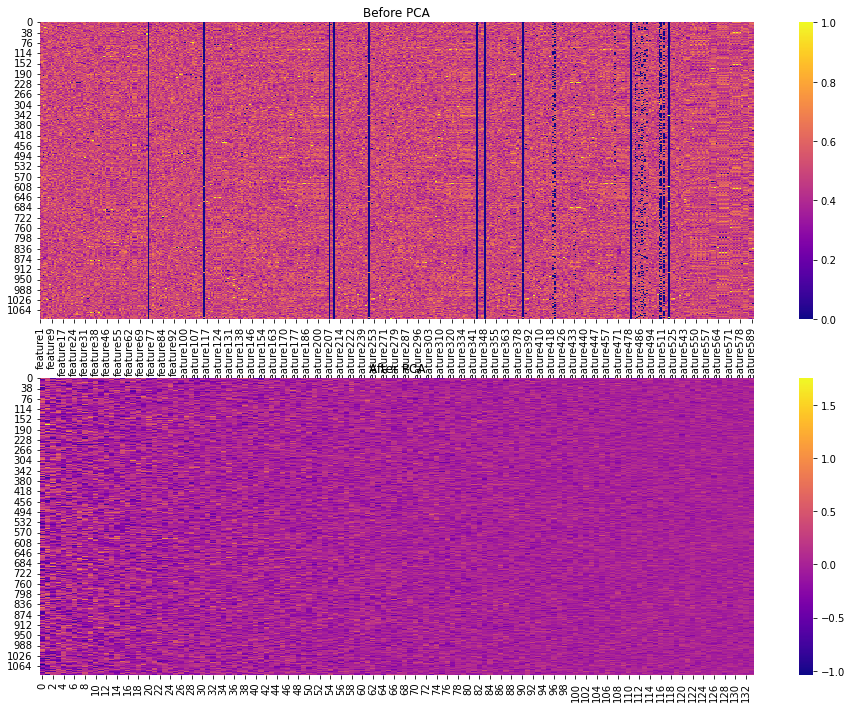

In [11]:
#x_train_Hot_deck2 = x_train_Hot_deck2.replace(np.NaN, 0)
#x_train_Hot_deck2.isnull().any().any()
#x_test_LastFill2 = x_test_Hot_deck2.replace(np.NaN, 0)
#x_test_LastFill2.isnull().any().any()

from sklearn.preprocessing import MinMaxScaler
col=list(x_train_LastFill2.columns)
col1=list(x_test_LastFill2.columns)
scaler = MinMaxScaler()
scaled_feature = scaler.fit_transform(x_train_LastFill2)
scaled_feature = pd.DataFrame(scaled_feature,columns=col)

from sklearn.decomposition import PCA
import numpy as np
# Creating a covariance matrix

cov_matrix = np.cov(scaled_feature.T)
print('Covariance Matrix \n', cov_matrix)
      
#perform an eigendecomposition on the covariance matrix:

eig_vals, eig_vecs = np.linalg.eig(cov_matrix)  


tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)



plt.figure(figsize=(12 ,6))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()  


pca = PCA(n_components=scaled_feature.shape[1],random_state=1).fit(scaled_feature.values)
a = np.cumsum(pca.explained_variance_ratio_)


i = 0
while a[i] < 0.9:
    i = i+1
f'Number of dimensions needed to capture 90%% of variance:{i}'


# PCA with reduced number of components

pca = PCA(n_components=i,random_state=1)
pca.fit(scaled_feature)
#print(pca.components_)

pca_df= pd.DataFrame(pca.fit_transform(scaled_feature))
print(pca_df)


pca_df.shape

#heatmap before and after PCA
# after PCA shows that the components are in the acceptable range of colinearity: means that the components are independent and  suitable for model making.
f, (ax_heatmap, ax_heatmap2) = plt.subplots(2,figsize=(16,12))
ax_heatmap.set_title('Before PCA')
ax_heatmap2.set_title('After PCA')

sns.heatmap(scaled_feature,ax=ax_heatmap,cmap='plasma');
sns.heatmap(pca_df,ax=ax_heatmap2,cmap='plasma');


from sklearn.decomposition import PCA
# create a PCA object
pca = PCA(n_components = i)# extracted features we want to end up within our new dataset(2).
# Apply the above object to our training dataset using the fit method.
X_train = pca.fit_transform(x_train_LastFill2)
# Apply the PCA object to the test set only to transform this set
X_test = pca.fit_transform(x_test_LastFill2)

## Evaluation Check

In [12]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#from sklearn.metrics import scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

classifiers = [['Naive Bayes :', GaussianNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['LogisticRegression :', LogisticRegression()],
               ['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()]]

for name,classifier in classifiers:
    clf=classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(X_train,y_train) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_test,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred)}' )


 Naive Bayes : 

Training Score for Naive Bayes :  95.07
Testing Score for Naive Bayes : 39.07
Classification report  
               precision    recall  f1-score   support

          -1       0.95      0.37      0.53       440
           1       0.08      0.74      0.14        31

    accuracy                           0.39       471
   macro avg       0.51      0.55      0.33       471
weighted avg       0.89      0.39      0.50       471

Confusion matrix  
 [[161 279]
 [  8  23]]
ROC AUC  : 0.5539222873900294

 KNeighbours : 

Training Score for KNeighbours :  93.61
Testing Score for KNeighbours : 93.21
Classification report  
               precision    recall  f1-score   support

          -1       0.93      1.00      0.96       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471

Confusion matrix  
 [[439   1]
